In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd /content/gdrive/MyDrive/Thư mục không có tiêu đề/Project3_improved/P3_Customer_Segmentation/Data_&_Workbook

Mounted at /content/gdrive
/content/gdrive/MyDrive/Thư mục không có tiêu đề/Project3_improved/P3_Customer_Segmentation/Data_&_Workbook


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
master_df = pd.read_csv('Data/CDNOW_master.txt', header=None)
master_df = master_df.apply(lambda x: x.replace("  ", " "))
master_df = master_df[0].str.split(expand=True)
master_df = master_df.rename(columns = {0:'customer_id', 
                                        1:'date', 
                                        2:'purchased_quantity', 
                                        3:'sale'})
master_df.date = pd.to_datetime(master_df.date)

# EDA

In [4]:
master_df.head()

,customer_id,date,purchased_quantity,sale
0,00001,1997-01-01,1,11.77
1,00002,1997-01-12,1,12.00
2,00002,1997-01-12,5,77.00
3,00003,1997-01-02,2,20.76
4,00003,1997-03-30,2,20.76


In [5]:
master_df.shape

(69659, 4)

In [6]:
master_df.to_csv('CDnow_MasterData.csv', index=False)

In [7]:
# change data types
master_df.purchased_quantity = master_df.purchased_quantity.astype('int')
master_df.sale = master_df.sale.astype('float')

In [8]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         69659 non-null  object        
 1   date                69659 non-null  datetime64[ns]
 2   purchased_quantity  69659 non-null  int64         
 3   sale                69659 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [9]:
master_df.shape

(69659, 4)

In [10]:
master_df.describe()

,purchased_quantity,sale
count,69659.000000,69659.000000
mean,2.410040,35.893648
std,2.333924,36.281942
min,1.000000,0.000000
25%,1.000000,14.490000
50%,2.000000,25.980000
75%,3.000000,43.700000
max,99.000000,1286.010000


In [11]:
# check for missing values
def missing_value(df):
    columns = df.columns.values.tolist()
    for i in columns:
        s = df[i].isnull().sum()
        if s > 0:
            print(f"'{i}' has missing values: {s}")
        else:
            print(f"'{i}' has no missing values")

missing_value(master_df)

'customer_id' has no missing values
'date' has no missing values
'purchased_quantity' has no missing values
'sale' has no missing values


In [12]:
# check for duplicates
print(f"Sum of duplicates: {master_df.duplicated().sum()}")
print(f"\nShow duplicates:\n{master_df[master_df.duplicated(keep=False)]}")

Sum of duplicates: 255

Show duplicates:
      customer_id       date  purchased_quantity   sale
1380        00398 1998-05-18                   1  12.99
1381        00398 1998-05-18                   1  12.99
1664        00499 1997-10-01                   1  11.49
1665        00499 1997-10-01                   1  11.49
1666        00499 1997-10-01                   1  15.49
...           ...        ...                 ...    ...
69151       23373 1998-01-14                   1  12.99
69177       23380 1998-06-09                   1   9.49
69178       23380 1998-06-09                   1   9.49
69217       23394 1997-08-04                   1  11.77
69218       23394 1997-08-04                   1  11.77

[470 rows x 4 columns]


## Feature Engineering: order_id

- Ta có Mỗi observation trong master_df là một transaction. 1 lần mua hàng hay 1 order_id có thể gồm nhiều transactions. 

- Trong bài này, dựa trên dữ liệu hiện có thực hiện định nghĩa những transactions (observations) nào có customer_id và date giống nhau thì sẽ có cùng order_id và được tính là 1 lần mua hàng.

In [13]:
# tạo duplicated dataframe
duplicated = master_df[master_df[['customer_id', 'date']].duplicated(keep='first')]
duplicated

,customer_id,date,purchased_quantity,sale
2,00002,1997-01-12,5,77.00
33,00008,1997-11-16,7,50.43
87,00029,1997-07-13,2,26.74
147,00040,1997-09-14,1,13.99
148,00040,1997-09-14,1,22.99
...,...,...,...,...
69177,23380,1998-06-09,1,9.49
69178,23380,1998-06-09,1,9.49
69218,23394,1997-08-04,1,11.77
69356,23454,1997-03-25,1,14.96


In [14]:
# lấy index của các duplicates theo từng nhóm và thực hiện đặt order_id cho các nhóm
df_new = master_df.copy(deep=True)
df_new['order_id'] = 0

duplicate_idx = []

for index, col in duplicated.iterrows():
    data = df_new[(df_new['customer_id'] == col['customer_id'])
                  & (df_new['date'] == col['date'])]
    
    if data.shape[0] > 0:
        duplicate_idx.append(data.index)
k = 1
for i in duplicate_idx:
    df_new.loc[i, 'order_id'] = k
    k += 1
    
# lấy index của các nhóm không có cùng customer_id và date
duplicate_idx = df_new[df_new[['customer_id', 'date']].duplicated(keep=False)]['order_id'].index
nondub_idx = df_new.drop(index = duplicate_idx, axis = 0).index

# thực hiện gán order_id cho các observations không có cùng customer_id và date
k = 2069
for n in nondub_idx:
    df_new.loc[n, 'order_id'] = k
    k+=1

In [15]:
len(duplicate_idx)

3842

In [16]:
# kiểm tra order_id được thiết lặp cho các nhóm có cùng customer_id và date
df_new[df_new[['customer_id', 'date']].duplicated(keep=False)]

,customer_id,date,purchased_quantity,sale,order_id
1,00002,1997-01-12,1,12.00,1
2,00002,1997-01-12,5,77.00,1
32,00008,1997-11-16,1,2.99,2
33,00008,1997-11-16,7,50.43,2
86,00029,1997-07-13,2,37.65,3
...,...,...,...,...,...
69218,23394,1997-08-04,1,11.77,2066
69355,23454,1997-03-25,1,11.77,2067
69356,23454,1997-03-25,1,14.96,2067
69395,23466,1997-03-25,2,30.67,2068


In [17]:
nondub_idx

Int64Index([    0,     3,     4,     5,     6,     7,     8,     9,    10,
               11,
            ...
            69649, 69650, 69651, 69652, 69653, 69654, 69655, 69656, 69657,
            69658],
           dtype='int64', length=65817)

In [19]:
# df_new.drop(['year', 'month'], axis = 1, inplace=True)

In [20]:
# kiểm tra order_id được thiết lặp cho các nhóm không có cùng customer_id và date
df_new.groupby(['customer_id', 'order_id']).sum()

purchased_quantity   sale
customer_id order_id                           
00001       2069                       1  11.77
00002       1                          6  89.00
00003       2070                       2  20.76
            2071                       2  20.76
            2072                       2  19.54
...                                  ...    ...
23568       67881                      4  83.74
            67882                      1  14.99
23569       67883                      2  25.74
23570       67884                      3  51.12
            67885                      2  42.96

[67591 rows x 2 columns]

In [21]:
# kiểm tra duplicate
df_new[df_new[['customer_id', 'date', 'purchased_quantity', 'sale']].duplicated(keep=False)]

,customer_id,date,purchased_quantity,sale,order_id
1380,00398,1998-05-18,1,12.99,34
1381,00398,1998-05-18,1,12.99,34
1664,00499,1997-10-01,1,11.49,48
1665,00499,1997-10-01,1,11.49,48
1666,00499,1997-10-01,1,15.49,48
...,...,...,...,...,...
69151,23373,1998-01-14,1,12.99,2063
69177,23380,1998-06-09,1,9.49,2065
69178,23380,1998-06-09,1,9.49,2065
69217,23394,1997-08-04,1,11.77,2066


In [22]:
# drop_duplicate
df_new[df_new[['customer_id', 'date', 'purchased_quantity', 'sale']].duplicated(keep=False)].index
df_new.drop(index = df_new[df_new[['customer_id', 'date', 'purchased_quantity', 'sale']].duplicated(keep=False)].index,
            axis = 0, inplace=True)

In [23]:
df_new.shape

(69189, 5)

In [24]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69189 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         69189 non-null  object        
 1   date                69189 non-null  datetime64[ns]
 2   purchased_quantity  69189 non-null  int64         
 3   sale                69189 non-null  float64       
 4   order_id            69189 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.2+ MB


In [25]:
df_new.to_csv('Data/master_clean.csv', index=False)

### Explore "date"

In [26]:
master_df = pd.read_csv('Data/master_clean.csv', dtype = {'customer_id' : 'object',
                                                         'purchased_quantity': 'int32',
                                                         'sale' : 'float64'})
# change data types
master_df.date = pd.to_datetime(master_df.date)
master_df.shape

(69189, 5)

In [27]:
print(f'master_df spans from {master_df.date.min()} to {master_df.date.max()}')

master_df spans from 1997-01-01 00:00:00 to 1998-06-30 00:00:00


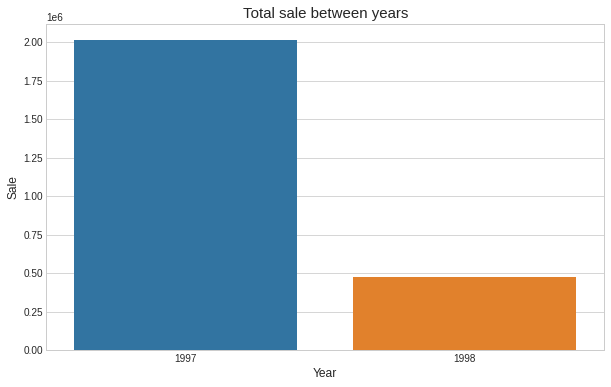

In [62]:
# sale of 2 years
master_df['year'] = master_df.date.apply(lambda x: x.year)
master_df['month'] = master_df.date.apply(lambda x: x.month)

year_sale = pd.DataFrame({'year': [1997, 1998],
                         'Total_sale': [round(master_df[master_df['year'] == 1997]['sale'].sum(), 2),
                                       round(master_df[master_df['year'] == 1998]['sale'].sum(),2)]})
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10, 6))
sns.barplot(data = year_sale, x='year', y='Total_sale')
plt.title('Total sale between years', fontsize=15)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Sale', fontsize = 12)
plt.show();

In [63]:
fig.savefig('Image/EDA_bar.png', dpi=300, bbox_inches='tight')

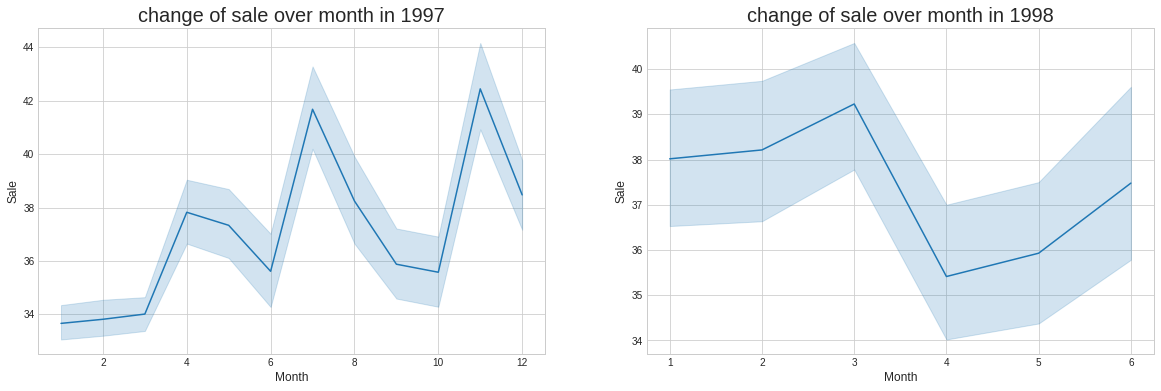

In [64]:
fig = plt.figure(figsize = (20, 6))

plt.subplot(1,2,1)
sns.lineplot(data = master_df[master_df['year'] == 1997], x='month', y='sale')
plt.title('change of sale over month in 1997', fontsize=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sale', fontsize = 12)

plt.subplot(1,2,2)
sns.lineplot(data = master_df[master_df['year'] == 1998], x='month', y='sale')
plt.title('change of sale over month in 1998', fontsize=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Sale', fontsize = 12)

plt.show();

In [65]:
fig.savefig('Image/EDA_line.png', dpi=300, bbox_inches='tight')

Nhận xét:
- Tuy bị thiếu dữ liệu trong 6 tháng, doanh thu 1998 vẫn nhỏ hơn 1/2 so doanh thu năm 1997
- Doanh thu giảm mạnh vào tháng 6 và tháng 10 năm 1997. Năm 1998 thì cho thấy doanh thu giảm đáng kể và tháng 4. Cả hai xu hướng có điểm chung là đều hồi phục và tăng trưởng sau đợt giảm mạnh.

## Explore "Purchased_quantity" and "Sale"

In [30]:
# check zero minus values in purchased_quantity
master_df[master_df['purchased_quantity'] <= 0]

,customer_id,date,purchased_quantity,sale,order_id,year,month


In [68]:
# check zero minus values in sale
master_df[master_df['sale'] <= 0].sum()

,customer_id,order_id,date,purchased_quantity,sale,scaled_quantity,scaled_sale,year,month


In [32]:
# xóa các cột có sale = 0
master_df.drop(index = master_df[master_df['sale'] <= 0].index, axis=0, inplace=True)

master_df.shape

(69109, 7)

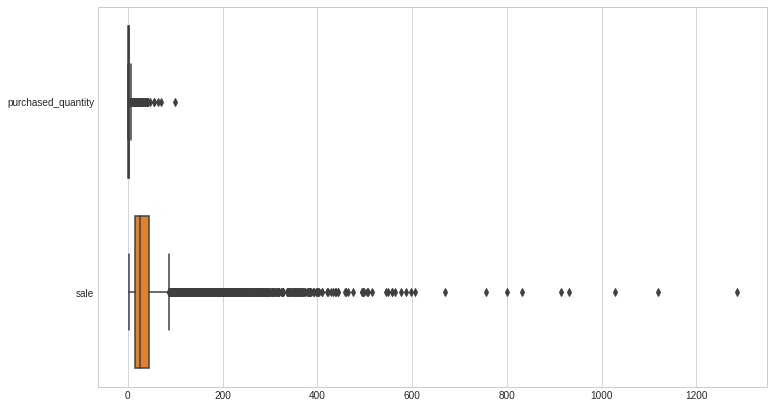

In [59]:
# xem outliner
plt.figure(figsize=(12, 7))
sns.boxplot(data=master_df[['purchased_quantity', 'sale']], orient = 'hh')
plt.show();

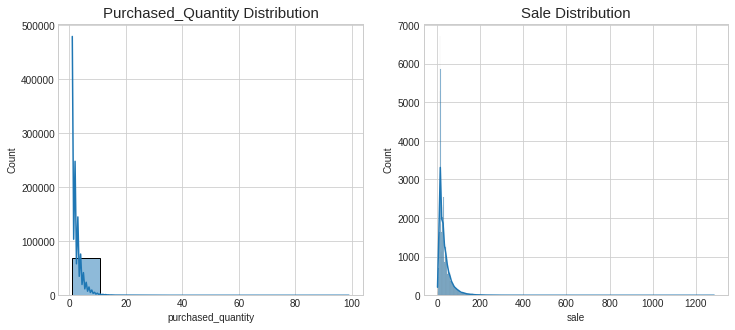

In [69]:
# xem distribution
fig = plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
sns.histplot(master_df.purchased_quantity, bins=10, kde=True)
plt.title('Purchased_Quantity Distribution', fontsize = 15)

plt.subplot(1,2,2)
sns.histplot(master_df.sale, kde=True)
plt.title('Sale Distribution', fontsize = 15)

plt.show();

In [70]:
fig.savefig('Image/EDA_dist.png', dpi=300, bbox_inches='tight')

Cần thực hiện scale dữ liệu. Vì dữ liệu có nhiều outliners => thực hiện Robust Scaler

In [35]:
from sklearn import preprocessing
robust_scaler = preprocessing.RobustScaler()
scaled = robust_scaler.fit_transform(master_df[['purchased_quantity', 'sale']])
scale_df = pd.DataFrame(scaled, columns=['scaled_quantity', 'scaled_sale'])

In [36]:
scale_df.head()

,scaled_quantity,scaled_sale
0,-0.5,-0.488435
1,-0.5,-0.480612
2,1.5,1.730272
3,0.0,-0.182653
4,0.0,-0.182653


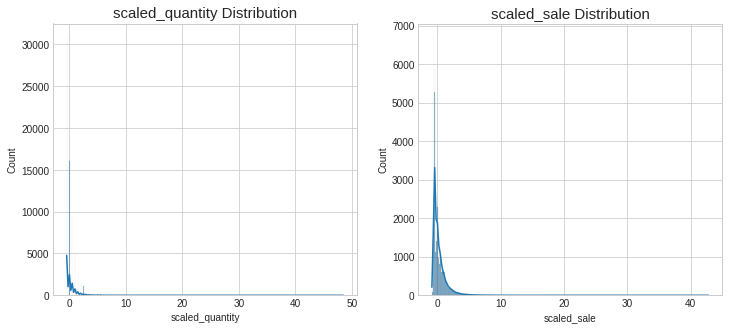

In [37]:
# xem distribution sau khi scale
plt.figure(figsize = (12, 5))
plt.subplot(1,2,1)
sns.histplot(scale_df.scaled_quantity, kde=True)
plt.title('scaled_quantity Distribution', fontsize = 15)

plt.subplot(1,2,2)
sns.histplot(scale_df.scaled_sale,  kde=True)
plt.title('scaled_sale Distribution', fontsize = 15)

plt.show();

In [38]:
scale_df.head()

,scaled_quantity,scaled_sale
0,-0.5,-0.488435
1,-0.5,-0.480612
2,1.5,1.730272
3,0.0,-0.182653
4,0.0,-0.182653


In [39]:
master_df = pd.concat([master_df, scale_df], axis=1, join='inner')

In [40]:
master_df.shape

(69029, 9)

In [41]:
master_df = master_df[['customer_id', 'order_id', 'date', 'purchased_quantity', 'sale','scaled_quantity', 'scaled_sale']]

In [42]:
master_df.head()

,customer_id,order_id,date,purchased_quantity,sale,scaled_quantity,scaled_sale
0,00001,2069,1997-01-01,1,11.77,-0.5,-0.488435
1,00002,1,1997-01-12,1,12.00,-0.5,-0.480612
2,00002,1,1997-01-12,5,77.00,1.5,1.730272
3,00003,2070,1997-01-02,2,20.76,0.0,-0.182653
4,00003,2071,1997-03-30,2,20.76,0.0,-0.182653


## Explore Customer_id & order_id

In [43]:
# Kiểm tra ký tự văn bản trong customer_id
master_df[master_df.customer_id.str.contains('[a-zA-Z]+', regex=True)]

,customer_id,order_id,date,purchased_quantity,sale,scaled_quantity,scaled_sale


In [44]:
# Trung bình một khách hàng thực hiện mua bao nhiều lần?
mean = master_df.groupby('customer_id')['order_id'].nunique().mean()
std = master_df.groupby('customer_id')['order_id'].nunique().std()
print(f"Trung bình một khách hàng thực hiện mua {round(mean, 2)} lần")
print(f"Với độ lệch chuẩn {round(std, 2)}")

Trung bình một khách hàng thực hiện mua 2.87 lần
Với độ lệch chuẩn 4.17


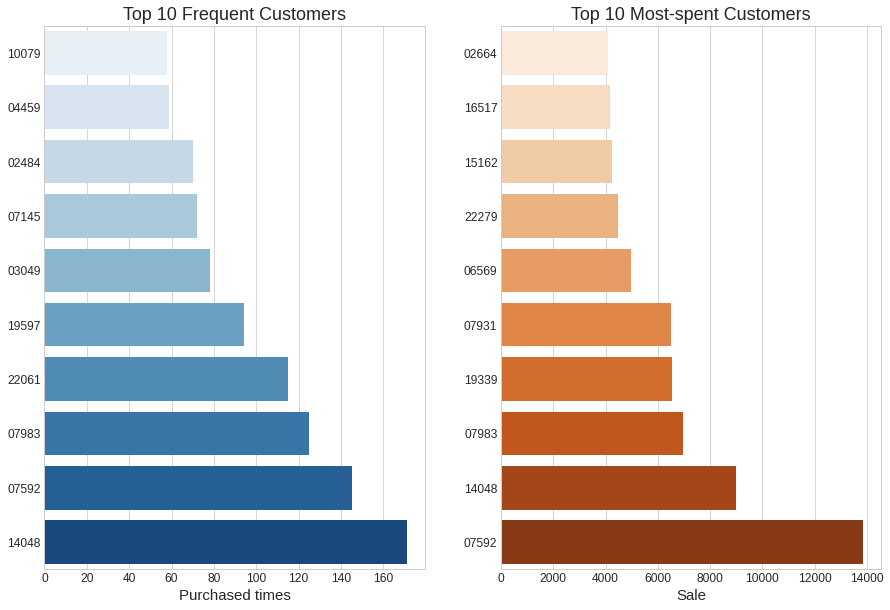

In [71]:
# xem customer có lượt mua nhiều nhất và khách hàng đem lại doanh thu cao nhất
top10_frequency = master_df.groupby('customer_id')['order_id'].nunique().sort_values(ascending=False)[:10]
top10_sale = master_df.groupby('customer_id')['sale'].sum().sort_values(ascending=False)[:10]

fig = plt.figure(figsize = (15, 10))
plt.subplot(1,2,1)
ax1 = sns.barplot(data = top10_frequency, 
                    x=top10_frequency.index, y=top10_frequency.values.tolist(), 
                    palette = 'Blues',
                   orient = 'h')
ax1.set_title('Top 10 Frequent Customers', fontsize = 18)
yticks = top10_frequency.sort_values().index.tolist()
ax1.set_yticklabels(yticks, fontsize = 12)
ax1.set_xlabel('Purchased times', fontsize = 15)
plt.setp(ax1.get_xticklabels(), fontsize = 12)

plt.subplot(1,2,2)
ax2 = sns.barplot(top10_sale, 
                  x=top10_sale.index, y = top10_sale.values.tolist(), 
                  orient = 'h', palette = 'Oranges')
ax2.set_title('Top 10 Most-spent Customers', fontsize = 18)
yticks = top10_sale.sort_values().index.tolist()
ax2.set_yticklabels(yticks, fontsize = 12)
ax2.set_xlabel('Sale', fontsize = 15)
plt.setp(ax2.get_xticklabels(), fontsize = 12)

#plt.tight_layout()
plt.show();

In [72]:
fig.savefig('Image/EDA_two_bar.png', dpi=300, bbox_inches='tight')

Nhận xét: 

Những khách hàng mua nhiều nhất không có nghĩa là họ đem lại nhiều doanh thu nhất

In [46]:
# lưu data frame đã được scale
master_df.to_csv('Data/Scaled_df.csv', index = False)

---
## Feature Engineering
- Recency (R)
- Frequency (F)
- Monetary Value (M)


In [49]:
max_date = master_df['date'].max()

recency = lambda x: (max_date - x.max()).days
frequency = lambda x: x.nunique()
monetary = lambda x: round(sum(x), 2)

df_RFM = master_df.groupby('customer_id').agg({
    'date' : recency,
    'order_id' : frequency,
    'sale' : monetary})

In [50]:
df_RFM.head()

,date,order_id,sale
customer_id,,,
00001,545,1,11.77
00002,534,1,89.00
00003,33,6,156.46
00004,200,4,100.50
00005,178,11,385.61


In [51]:
# rename df_RFM
df_RFM.columns = ['Recency', 'Frequency','Monetary']
df_rfm = df_RFM.sort_values('Monetary', ascending = False)

In [52]:
df_rfm.head()

,Recency,Frequency,Monetary
customer_id,,,
07592,1,145,13861.03
14048,0,171,8976.33
07983,5,125,6947.09
19339,445,22,6552.70
07931,17,53,6497.18


In [53]:
df_rfm.shape

(23446, 3)

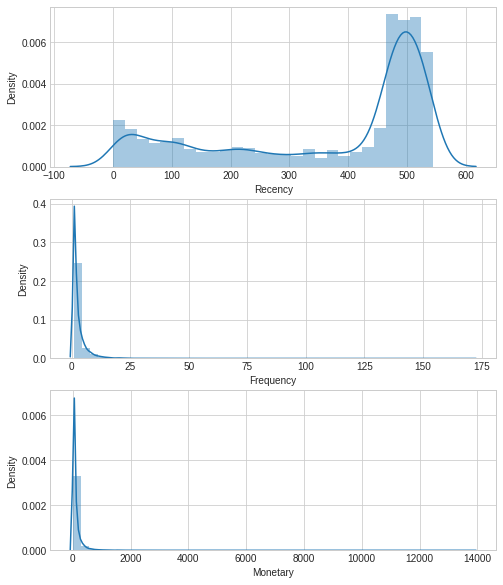

In [54]:
plt.figure(figsize=(8,10))
plt.subplot(3, 1, 1)
sns.distplot(df_rfm['Recency'])# Plot distribution of R
plt.subplot(3, 1, 2)
sns.distplot(df_rfm['Frequency'])# Plot distribution of F
plt.subplot(3, 1, 3)
sns.distplot(df_rfm['Monetary']) # Plot distribution of M
plt.show();

In [55]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5, 1)
m_labels = range(1, 5, 1)

[*r_labels]

[4, 3, 2, 1]

In [56]:
# Gán nhãn cho RFM
r_groups = pd.qcut(df_RFM['Recency'].rank(method='first'), q=4, labels=r_labels)

f_groups = pd.qcut(df_RFM['Frequency'].rank(method='first'), q=4, labels=f_labels)
 
m_groups = pd.qcut(df_RFM['Monetary'].rank(method='first'), q=4, labels=m_labels)

In [57]:
# Create new columns R, F, M
df_rfm = df_RFM.assign(R = r_groups.values, F = f_groups.values,  M = m_groups.values)
df_rfm.head()

,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
00001,545,1,11.77,1,1,1
00002,534,1,89.00,1,1,3
00003,33,6,156.46,4,4,4
00004,200,4,100.50,4,4,3
00005,178,11,385.61,4,4,4


In [58]:
df_rfm.to_csv('Data/RFM_data.csv', index=False)